In [1]:
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report, mean_squared_error, r2_score, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = '../drive-download-20241010T120556Z-001'
files = os.listdir(path)  
print(files)
df_books = pd.read_csv(f"{path}/{files[0]}")
df_checkouts = pd.read_csv(f"{path}/{files[1]}")
df_customers = pd.read_csv(f"{path}/{files[2]}")
df_lib = pd.read_csv(f"{path}/{files[3]}")


['books.csv', 'checkouts.csv', 'customers.csv', 'libraries.csv']


In [3]:
print(f"Shape for book.csv {df_books.shape}, avalible columns {df_books.columns.values}")
print(f"Shape for checkouts.csv {df_checkouts.shape}, avalible columns {df_checkouts.columns.values}")
print(f"Shape for customers.csv {df_customers.shape}, avalible columns {df_customers.columns.values}")
print(f"Shape for libraries.csv {df_lib.shape}, avalible columns {df_lib.columns.values}")

Shape for book.csv (240, 8), avalible columns ['id' 'title' 'authors' 'publisher' 'publishedDate' 'categories' 'price'
 'pages']
Shape for checkouts.csv (2000, 5), avalible columns ['id' 'patron_id' 'library_id' 'date_checkout' 'date_returned']
Shape for customers.csv (2000, 10), avalible columns ['id' 'name' 'street_address' 'city' 'state' 'zipcode' 'birth_date'
 'gender' 'education' 'occupation']
Shape for libraries.csv (18, 6), avalible columns ['id' 'name' 'street_address' 'city' 'region' 'postal_code']


### Data cleaning functions

In [4]:
def clean_string(value):
    value = str(value)
    value = value.replace(' ', '').upper()
    if value == "NAN":
        value = None
    return value

In [5]:
def clean_and_convert_date(date_series):

    cleaned_dates = (date_series.str.replace(r'\|', '-', regex=True)       
                                .str.replace(r'%|/', '', regex=True)       
                                .str.replace(r'\s+', ' ', regex=True)      
                                .str.strip())
    
    converted_dates = pd.to_datetime(cleaned_dates, format = 'mixed', errors='coerce', dayfirst=True)
    return converted_dates

In [6]:
def clean_numbers(number):
    if pd.isnull(number):
        return None
    number = re.sub(r'[^\d.]', '', str(number))
    if number.count('.') > 1:
        return None

    try:
        return float(number)
    except ValueError:
        return None 

In [7]:
def switch_dates(row):
    if row['checkout_period'] < 0:
        temp = row['c_date_checkout']
        row['c_date_checkout'] = row['c_date_returned']
        row['c_date_returned'] = temp
    return row

#### Cleaning libraries.csv

In [8]:
df_lib['c_postal_code'] = df_lib['postal_code'].apply(clean_numbers)
df_lib['c_city'] = df_lib['city'].apply(clean_string)
df_lib['c_region'] = df_lib['region'].apply(clean_string)
df_lib_c = df_lib.drop(columns= ["city", "region", "postal_code", "c_city", "c_region"])
df_lib_c = df_lib_c.rename(columns= {"id": "library_id"})
df_lib_c.head()

,library_id,name,street_address,c_postal_code
0,226-222@5xc-kc4-fpv,Multnomah County Library Capitol Hill,10723 SW capitol Hwy,97219.0
1,23v-222@5xc-jv7-v4v,Multnomah County Library Northwest,2300 NW Thurman St,NaN
2,222-222@5xc-jvf-skf,Multnomah County Library St Johns,7510 N Charleston Ave,97203.0
3,227-222@5xc-jww-btv,Multnomah County Library Hillsdale,1525 SW Sunset blvd,97239.0
4,22d-222@5xc-kcy-8sq,Multnomah County Library Sellwood Moreland,7860 SE 13th AVE,97202.0


In [9]:
df_lib_c.isnull().sum()

library_id        0
name              0
street_address    0
c_postal_code     3
dtype: int64

#### Cleaning customers.csv

In [10]:
print("Missing values in each column:")
print(df_customers.isnull().sum())

Missing values in each column:
id                  0
name                0
street_address      0
city               94
state             102
zipcode             1
birth_date        107
gender            101
education         104
occupation        107
dtype: int64


In [11]:
df_customers['c_zipcode'] = df_customers['zipcode'].apply(clean_numbers)
df_customers['c_gender'] = df_customers['gender'].apply(clean_string)
df_customers['c_city'] = df_customers['city'].apply(clean_string)
df_customers['c_state'] = df_customers['state'].apply(clean_string)
df_customers['c_occupation'] = df_customers['occupation'].apply(clean_string)
df_customers['c_education'] = df_customers['education'].apply(clean_string)
df_customers['c_birth_date'] = clean_and_convert_date(df_customers['birth_date'])
df_customers_c = df_customers.drop(columns=['zipcode','gender','city','state','occupation','education','birth_date'])

df_customers_c = df_customers_c.rename(columns={"id":"customer_id"})

In [12]:
print("Missing values in each column:")
print(df_customers_c.isnull().sum())

Missing values in each column:
customer_id         0
name                0
street_address      0
c_zipcode           1
c_gender          101
c_city             94
c_state           102
c_occupation      107
c_education       104
c_birth_date      107
dtype: int64


#### Cleaning book.csv

In [13]:
print("Missing values in each column:")
print(df_books.isnull().sum())

Missing values in each column:
id                 0
title              0
authors           67
publisher        146
publishedDate      2
categories        39
price              2
pages              0
dtype: int64


In [14]:
df_books['c_categories'] = df_books['categories'].apply(clean_string)
df_books['c_publishedDate'] = clean_and_convert_date(df_books['publishedDate'])
df_books['c_price'] = df_books['price'].apply(clean_numbers)
df_books['c_pages'] = df_books['pages'].apply(clean_numbers)

In [15]:
df_books_c = df_books.drop(columns=['publishedDate','categories','price','pages'])
df_books_c = df_books_c.rename(columns={"id":"book_id"})

In [16]:
print("Missing values in each column:")
print(df_books_c.isnull().sum())

Missing values in each column:
book_id              0
title                0
authors             67
publisher          146
c_categories        39
c_publishedDate      2
c_price              2
c_pages              0
dtype: int64


#### Cleaning checkouts.csv

In [17]:
print("Missing values in each column:")
print(df_checkouts.isnull().sum())

Missing values in each column:
id                0
patron_id         0
library_id        0
date_checkout    65
date_returned    58
dtype: int64


In [18]:
df_checkouts['c_date_checkout'] = clean_and_convert_date(df_checkouts['date_checkout'])
df_checkouts['c_date_returned'] = clean_and_convert_date(df_checkouts['date_returned'])
df_checkouts['checkout_period'] = (df_checkouts['c_date_returned']- df_checkouts['c_date_checkout']).dt.days

df_checkouts = df_checkouts.apply(switch_dates, axis=1)
df_checkouts_c = df_checkouts.drop(columns=["date_checkout","date_returned"])
df_checkouts_c = df_checkouts_c.rename(columns={"id":"book_id", "patron_id":"customer_id"})

In [19]:
print("Missing values in each column:")
print(df_checkouts_c.isnull().sum())

Missing values in each column:
book_id              0
customer_id          0
library_id           0
c_date_checkout     65
c_date_returned     58
checkout_period    123
dtype: int64


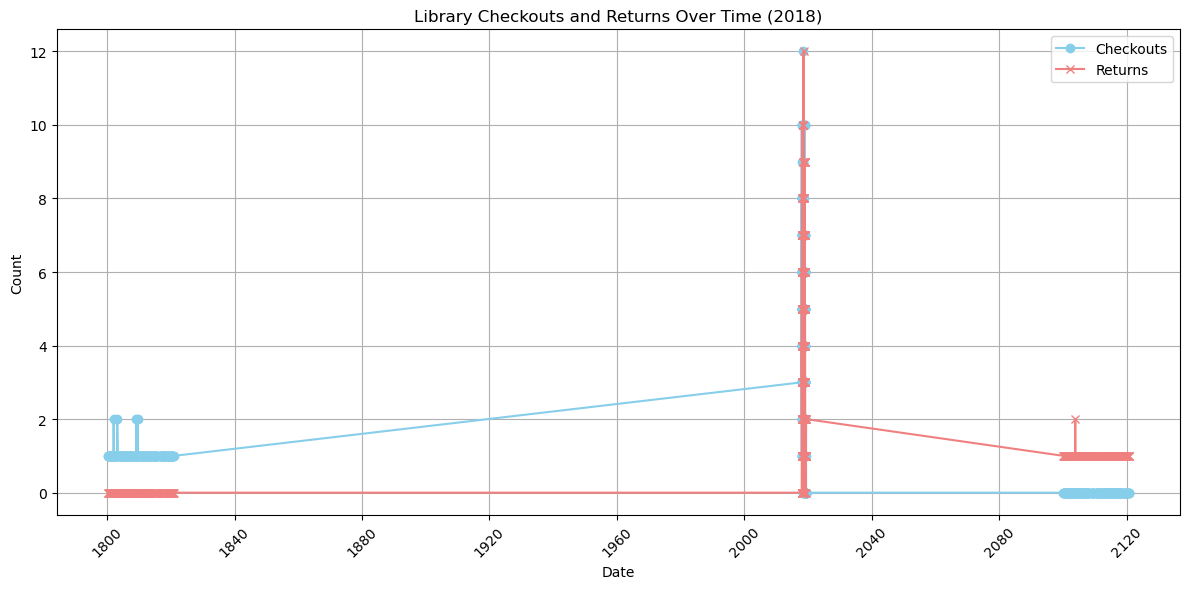

In [20]:
df_filtered = df_checkouts_c.dropna(subset=['c_date_checkout', 'c_date_returned'])

checkouts_by_date = df_filtered['c_date_checkout'].value_counts().sort_index()
returns_by_date = df_filtered['c_date_returned'].value_counts().sort_index()

combined_df = pd.DataFrame({
    'Checkouts': checkouts_by_date,
    'Returns': returns_by_date
}).fillna(0)  

plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Checkouts'], label='Checkouts', color='skyblue', marker='o')
plt.plot(combined_df.index, combined_df['Returns'], label='Returns', color='lightcoral', marker='x')

plt.title('Library Checkouts and Returns Over Time (2018)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
del df_filtered

In [21]:
df_checkouts_c

,book_id,customer_id,library_id,c_date_checkout,c_date_returned,checkout_period
0,-xFj0vTLbRIC,b071c9c68228a2b1d00e6f53677e16da,225-222@5xc-jtz-hkf,2018-11-13,2019-01-28,-76.0
1,HUX-y4oXl04C,8d3f63e1deed89d7ba1bf6a4eb101373,223-222@5xc-jxr-tgk,2018-05-29,2018-06-12,14.0
2,TQpFnkku2poC,4ae202f8de762591734705e0079d76df,228-222@5xc-jtz-hwk,2018-11-23,2019-01-24,62.0
3,OQ6sDwAAQBAJ,f9372de3c8ea501601aa3fb59ec0f524,23v-222@5xc-jv7-v4v,2018-01-15,2018-04-25,100.0
4,7T9-BAAAQBAJ,2cf3cc3b9e9f6c608767da8d350f77c9,225-222@5xc-jtz-hkf,1804-01-23,2018-12-31,-78505.0
...,...,...,...,...,...,...
1995,rNbuDwAAQBAJ,91871955f3641857832766ac3f5a0b95,222-222@5xc-jv5-nt9,2018-07-19,2018-08-12,24.0
1996,rcrCAgAAQBAJ,ad08956eb20efb746af650f906d439cf,22d-222@5xc-kcy-8sq,2018-03-07,2018-03-13,6.0
1997,F44fAQAAMAAJ,026262cc3454149303074c4113b5f118,226-222@5xc-jxj-7yv,2018-06-17,2018-06-27,10.0
1998,Ci1HAQAAMAAJ,08b29865e58e9b2aabff9684a703acf0,223-222@5xc-jxr-tgk,2018-12-10,2018-12-29,19.0


In [22]:
df_checkouts_c = df_checkouts_c.apply(switch_dates, axis=1)
df_checkouts_c['checkout_period'] = (df_checkouts_c['c_date_returned'] - df_checkouts_c['c_date_checkout']).dt.days


In [23]:

missing_data = df_checkouts_c.isnull().sum()
print(missing_data[missing_data > 0])


c_date_checkout     65
c_date_returned     58
checkout_period    123
dtype: int64


### Data Analysis 

#### *The main idea here was to find relationships between the data, before running the model*

In [24]:
df_checkouts_c['is_late_return'] = df_checkouts['c_date_returned'] > (df_checkouts['c_date_checkout'] + pd.Timedelta(days=28))
late_return_rates = df_checkouts_c.groupby('book_id')['is_late_return'].mean()


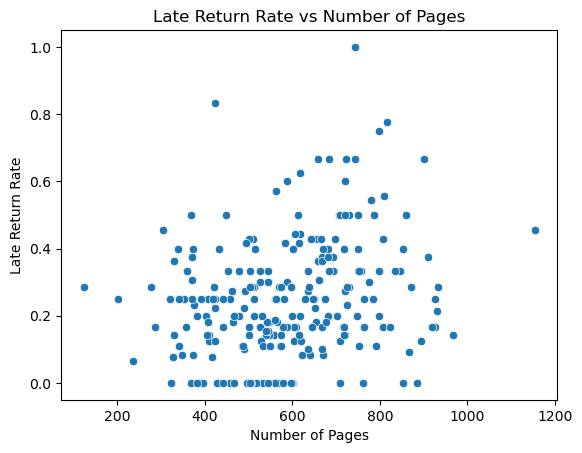

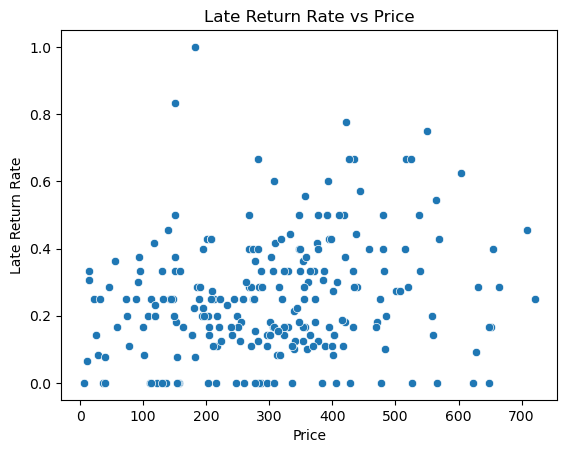

In [25]:
late_returns_df = df_books_c.merge(late_return_rates, on='book_id')

sns.scatterplot(data=late_returns_df, x='c_pages', y='is_late_return')
plt.title('Late Return Rate vs Number of Pages')
plt.xlabel('Number of Pages')
plt.ylabel('Late Return Rate')
plt.show()

sns.scatterplot(data=late_returns_df, x='c_price', y='is_late_return')
plt.title('Late Return Rate vs Price')
plt.xlabel('Price')
plt.ylabel('Late Return Rate')
plt.show()

##### *Based on these results, it is concluded that books with more pages have a higher late return.*

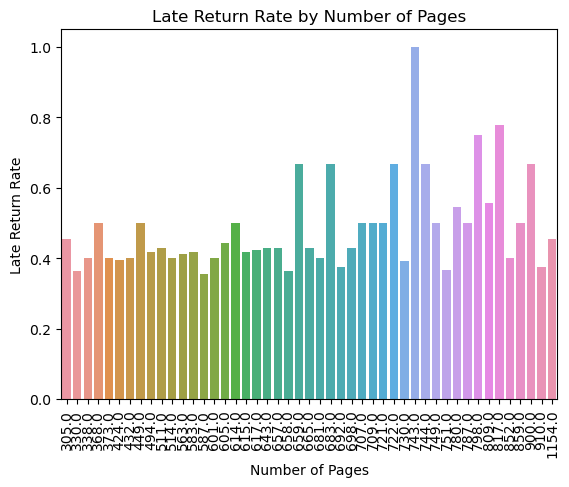

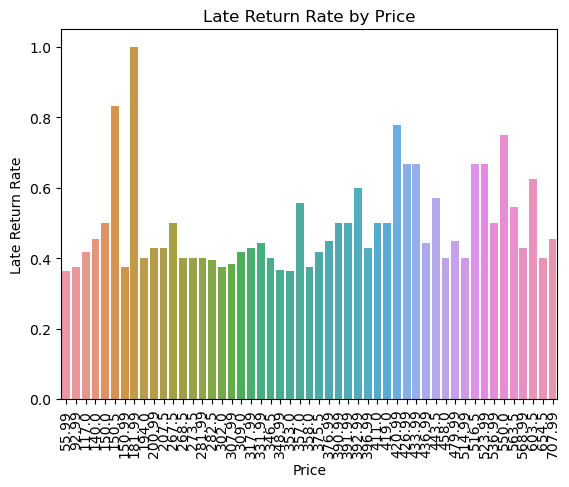

In [26]:
late_returns_df = df_books_c.merge(late_return_rates, on='book_id')
late_rerutns_pages = late_returns_df.groupby('c_pages')['is_late_return'].mean().reset_index()

sns.barplot(data=late_rerutns_pages[late_rerutns_pages.is_late_return>0.35], x='c_pages', y='is_late_return')
plt.title('Late Return Rate by Number of Pages')
plt.xlabel('Number of Pages')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()

late_rerutns_price = late_returns_df.groupby('c_price')['is_late_return'].mean().reset_index()

sns.barplot(data=late_rerutns_price[late_rerutns_price.is_late_return>0.35], x='c_price', y='is_late_return')
plt.title('Late Return Rate by Price')
plt.xlabel('Price')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()

##### *Merging datasets to better understand data and remove unusable dates*

In [27]:
df_merged = pd.merge(df_customers_c, df_checkouts_c, on='customer_id')

df_final = pd.merge(df_merged, df_books_c, on='book_id', how='left')
df_final.dropna(subset=['c_date_checkout','c_date_returned'], inplace= True)
valid_return = "2020-01-01" 
valid_return = datetime.strptime(valid_return, "%Y-%m-%d")
valid_check = "2017-01-01" 
valid_check = datetime.strptime(valid_check, "%Y-%m-%d")
vaild_bith = "1920-01-01"
vaild_bith = datetime.strptime(vaild_bith, "%Y-%m-%d")
# df_final = df_final[(df_final.c_birth_date>vaild_bith)]
# df_final = df_final[(df_final.c_birth_date<valid_return)]
df_final = df_final[(df_final.c_date_checkout>valid_check)]
df_final = df_final[(df_final.c_date_checkout<valid_return)]
df_final = df_final[(df_final.c_date_returned>valid_check)]
df_final = df_final[(df_final.c_date_returned<valid_return)]
df_final['age'] = (df_final['c_date_checkout'] - df_final['c_birth_date']).dt.days // 365
df_final.loc[(df_final.age>100) | (df_final.age<1),"age"] = None
df_final

,customer_id,name,street_address,c_zipcode,c_gender,c_city,c_state,c_occupation,c_education,c_birth_date,...,checkout_period,is_late_return,title,authors,publisher,c_categories,c_publishedDate,c_price,c_pages,age
0,df83ec2d0d409395c0d8c2690cfa8b67,Cynthia Barnfield,44 NE Meikle Pl,97213.0,FEMALE,PORTLAND,OREGON,None,HIGHSCHOOL,2009-09-10,...,21.0,False,Advertising For Dummies,['Gary Dahl'],John Wiley & Sons,['BUSINESS&ECONOMICS'],2011-04-18,177.50,329.0,8.0
1,6aec7ab2ea0d67161dac39e5dcabd857,Elizabeth Smith,7511 SE Harrison St,97215.0,FEMALE,PORTLAND,OREGON,BLUECOLLAR,COLLEGE,1956-12-15,...,24.0,False,Natural-bonded Molding Sand Resources of Illinois,['Max Sylvan Littlefield'],NaN,['SAND'],1925-01-01,92.99,371.0,61.0
2,0c54340672f510fdb9d2f30595c1ab53,Richard Pabla,1404 SE Pine St,97214.0,MALE,PORTLAND,OREGON,EDUCATION&HEALTH,COLLEGE,1960-12-18,...,6.0,False,The Elements of Mechanics,['Samuel Newth'],NaN,"['MECHANICS,ANALYTIC']",1869-01-01,140.00,305.0,57.0
3,f0d9ce833ddc1f73c1e0b55bdebf012e,Charles Baker,12271 N Westshore Dr,97217.0,MALE,PORTLAND,OREGON,SALES,GRADUATEDEGREE,2105-07-19,...,17.0,False,The Principles of Elementary Mechanics,['De Volson Wood'],NaN,['MECHANICS'],1893-01-01,14.00,370.0,NaN
4,3720379163f6b46944db6c98c0485bfd,Ronald Lydon,5321 NE Skyport Way,97218.0,MALE,None,OREGON,BLUECOLLAR,GRADUATEDEGREE,1961-03-14,...,20.0,False,Minnesota Medicine,NaN,NaN,['MEDICINE'],1921-01-01,267.99,507.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,ee6de600f37d70d179a77749cfa1901e,Antonio Collingwood,7040 N Olin Ave,97203.0,MALE,PORTLAND,OREGON,OTHERS,HIGHSCHOOL,2007-01-04,...,8.0,False,Moral Engines,"['Cheryl Mattingly', 'Rasmus Dyring', 'Maria L...",Berghahn Books,['PHILOSOPHY'],2017-10-01,443.50,563.0,11.0
1994,0dbfe4077fb31d5a5cf0e9636ecac677,Stanley Grove,1711 N Going St,97217.0,MALE,None,OREGON,None,HIGHSCHOOL,1806-03-10,...,19.0,False,Library of Advertising,['Axel Petrus Johnson'],NaN,['ADVERTISING'],1911-01-01,35.99,428.0,NaN
1995,ae55f0b71b8b8e91945cd9a91b6e45ee,JOE Roberts,7331 NE Killingsworth St,97218.0,MALE,PORTLAND,None,BUSINESS&FINANCE,OTHERS,1955-05-23,...,-27.0,False,Reports Submitted to the Council on Library Re...,"['Bolt, Beranek, and Newman, inc']",NaN,['INFORMATIONSTORAGEANDRETRIEVALSYSTEMS'],1963-01-01,390.99,614.0,63.0
1997,9a2194fcd4f0f326f0ca334450e16a93,Earl Grier,22 NE graham ST,97212.0,MALE,PORTLAND,OREGON,EDUCATION&HEALTH,OTHERS,2007-10-02,...,15.0,False,Water Resources Paper,NaN,NaN,['WATERRESOURCESDEVELOPMENT'],1952-01-01,258.50,582.0,10.0


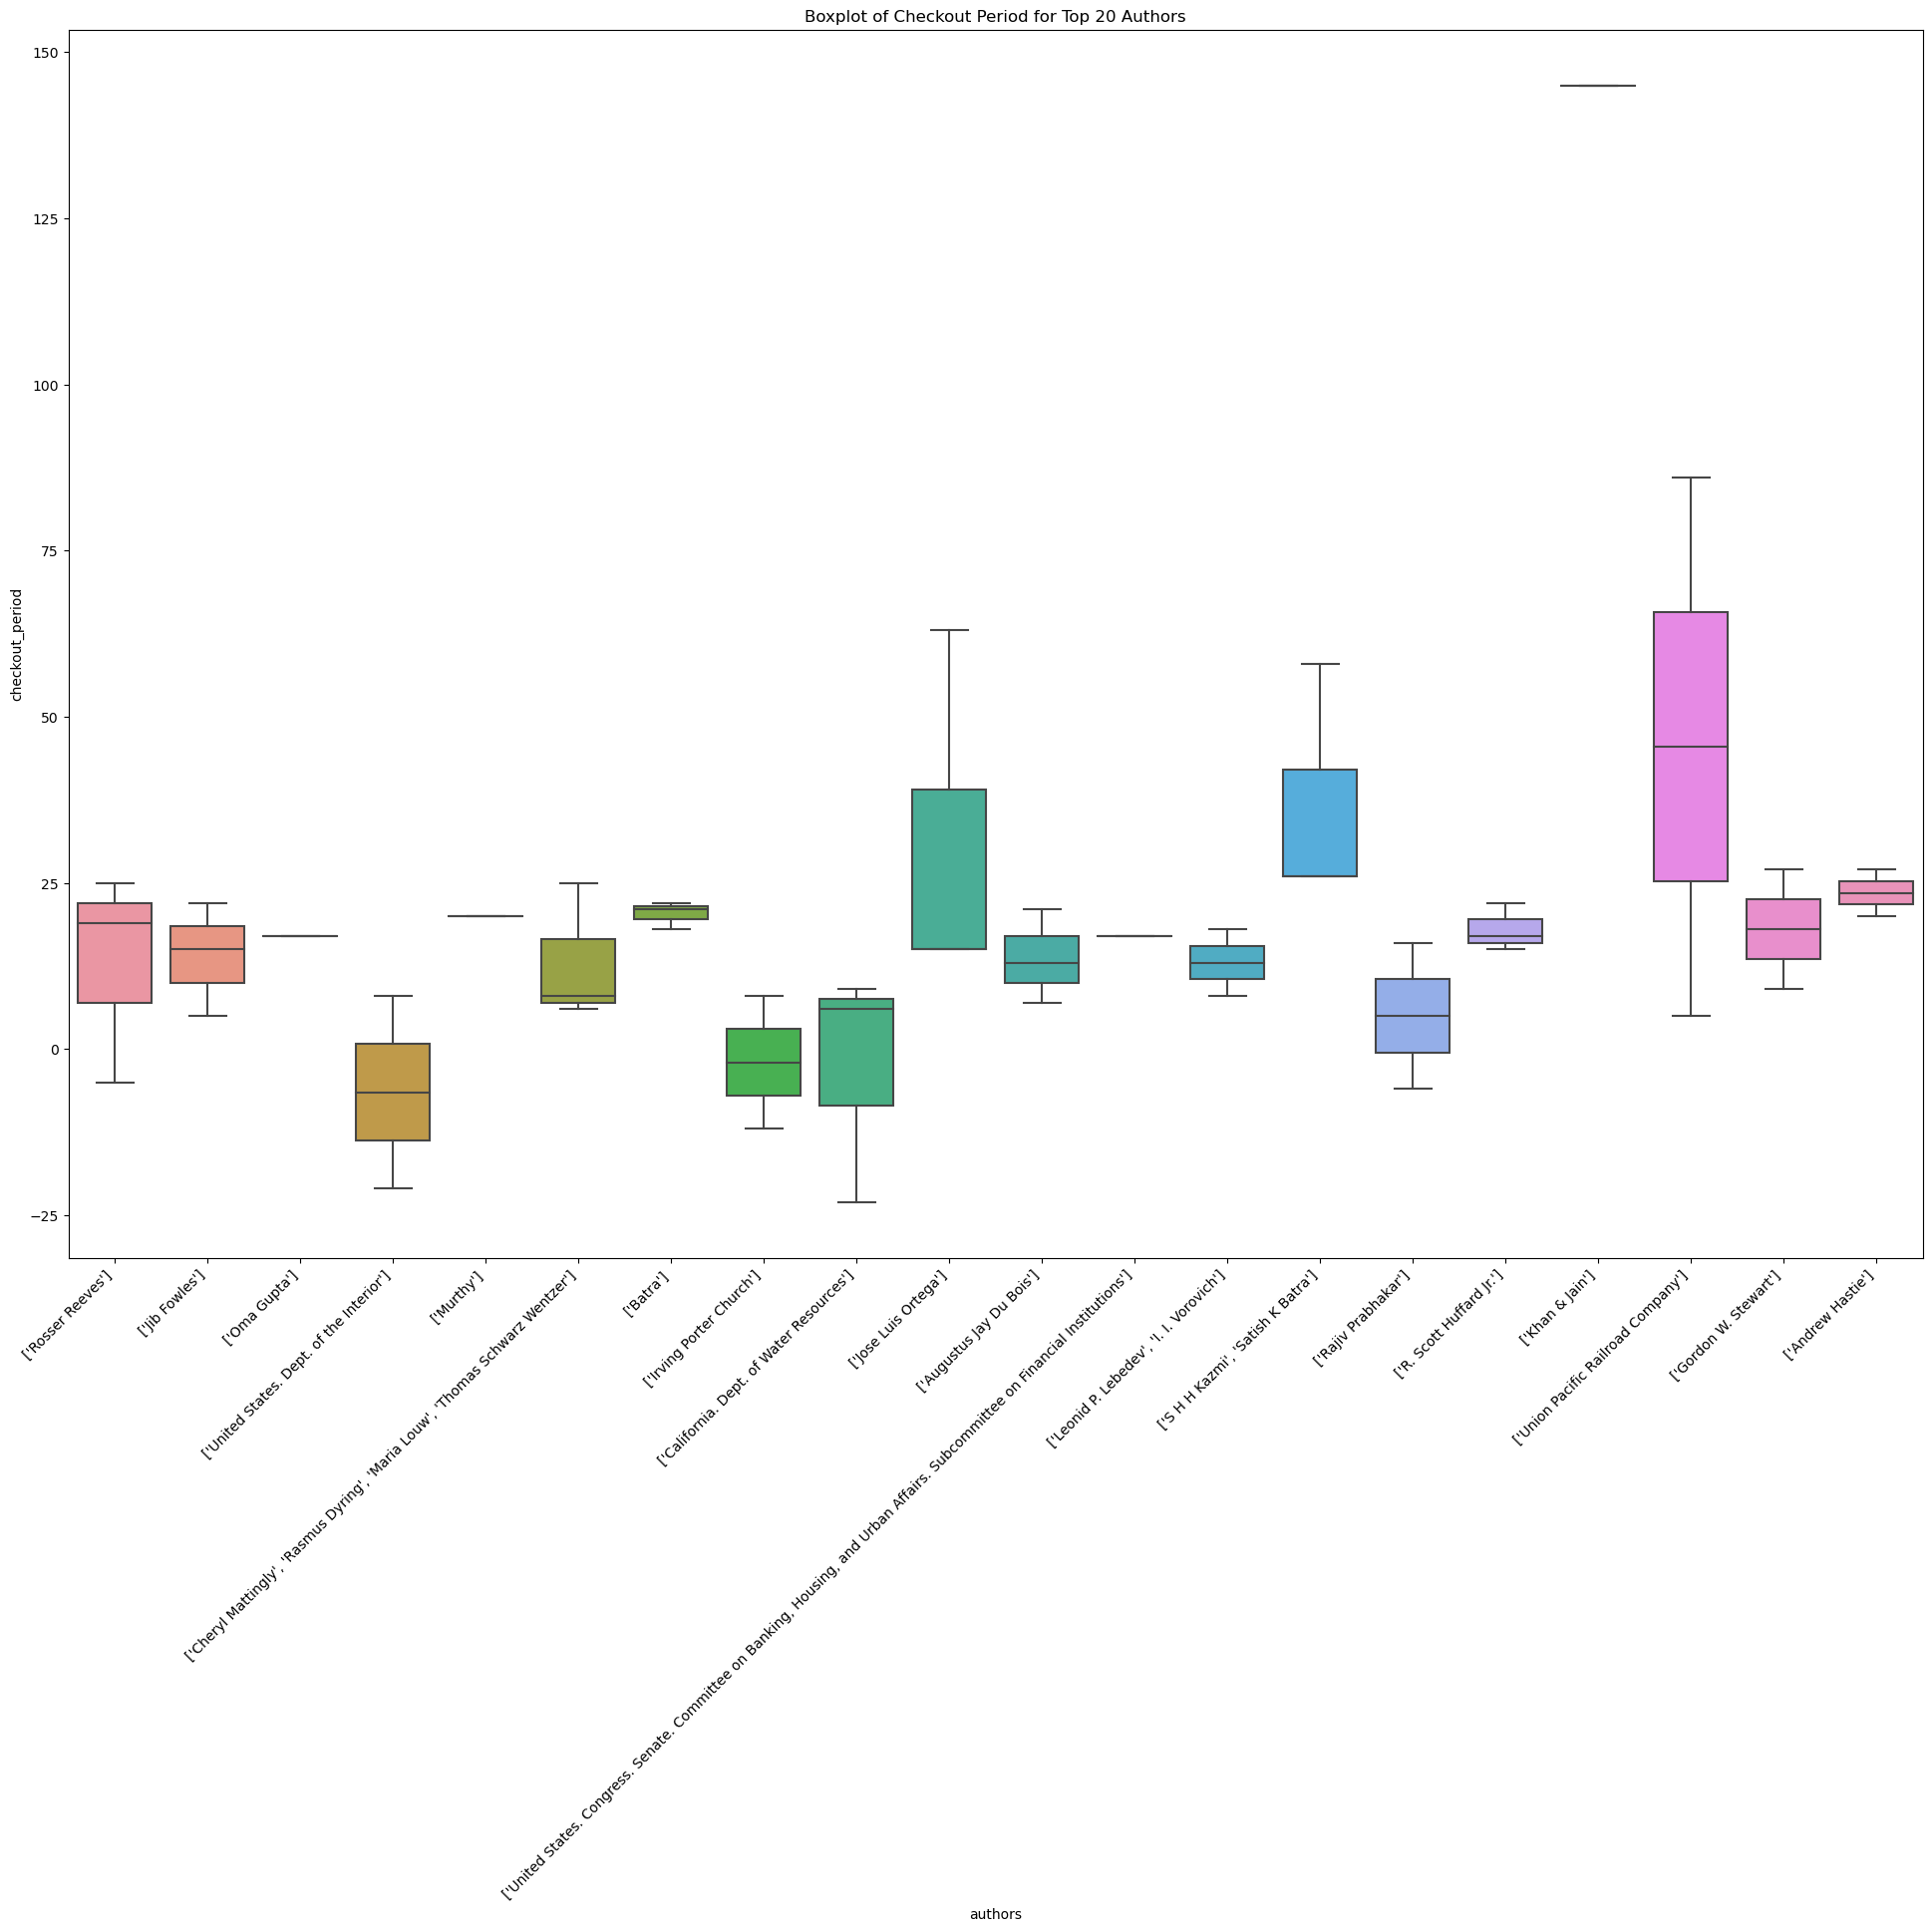

In [28]:

top_authors = df_final['authors'].value_counts().sort_values().head(20).index

df_top_authors = df_final[df_final['authors'].isin(top_authors)]

plt.figure(figsize=(24, 16))
sns.boxplot(x="authors", y="checkout_period", data=df_top_authors)
plt.title('Boxplot of Checkout Period for Top 20 Authors')
plt.xticks(rotation=45, ha = 'right')
plt.show()

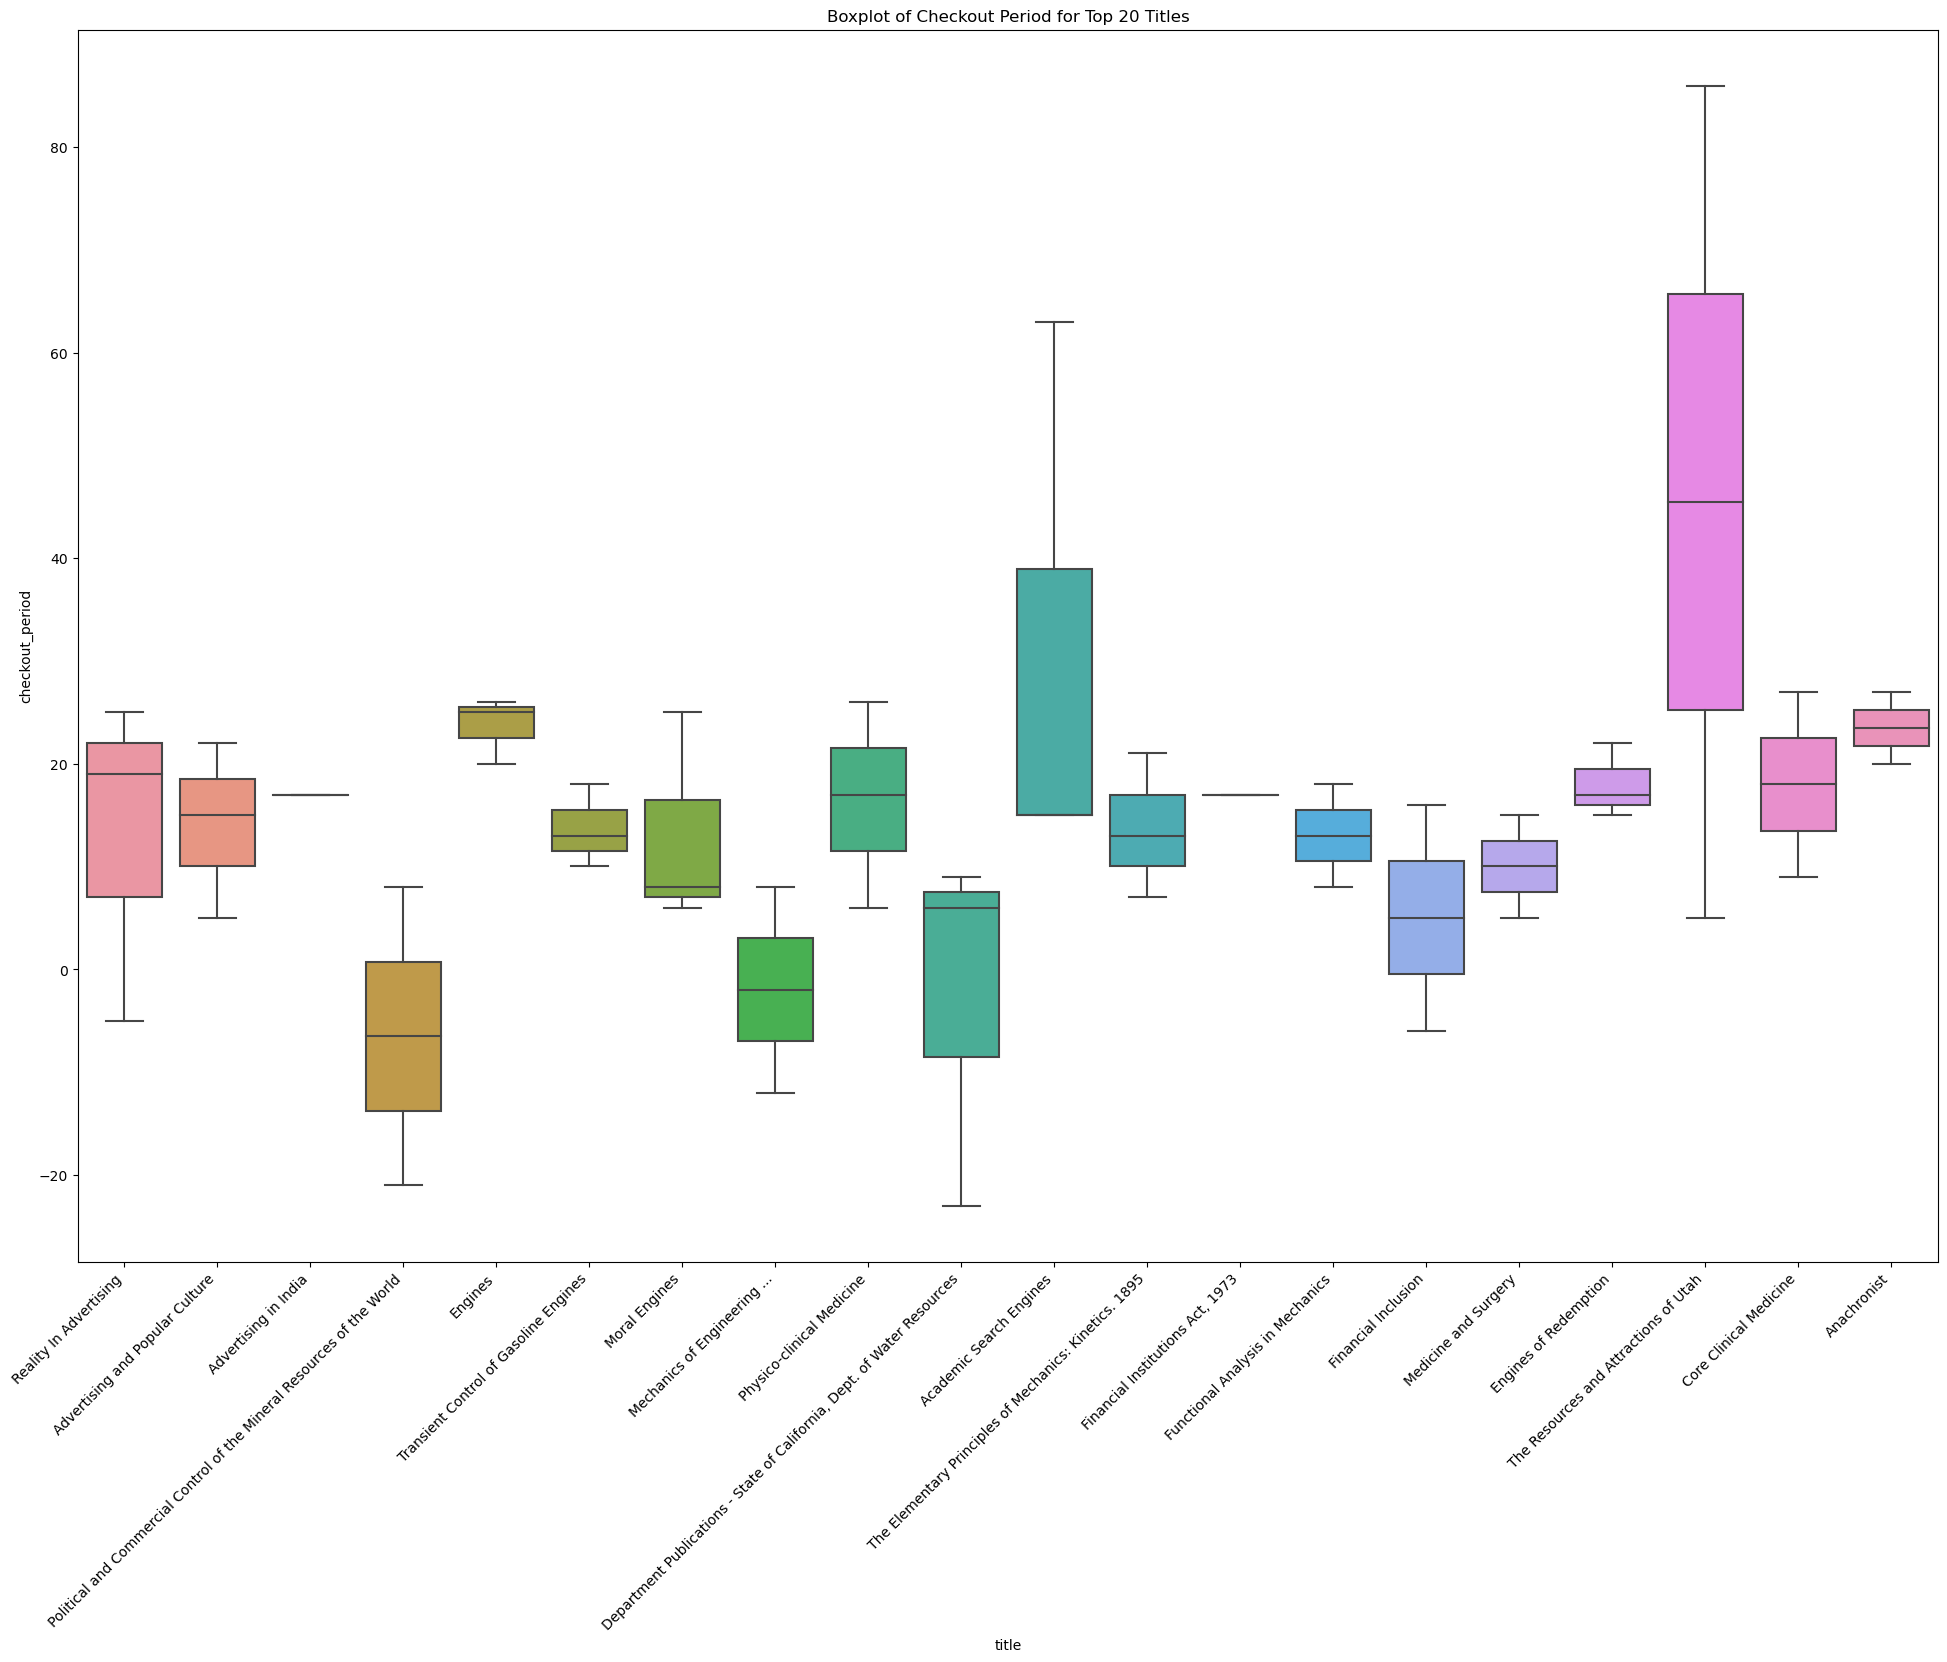

In [29]:
top_books = df_final['title'].value_counts().sort_values().head(20).index

df_top_books = df_final[df_final['title'].isin(top_books)]

plt.figure(figsize=(24, 16))
sns.boxplot(x="title", y="checkout_period", data=df_top_books)
plt.title('Boxplot of Checkout Period for Top 20 Titles')
plt.xticks(rotation=45, ha = 'right')
plt.show()

##### *The idea of these boxplots was to show the distribution of of checking period, to understand whether the late return is random or the rule for that book.*

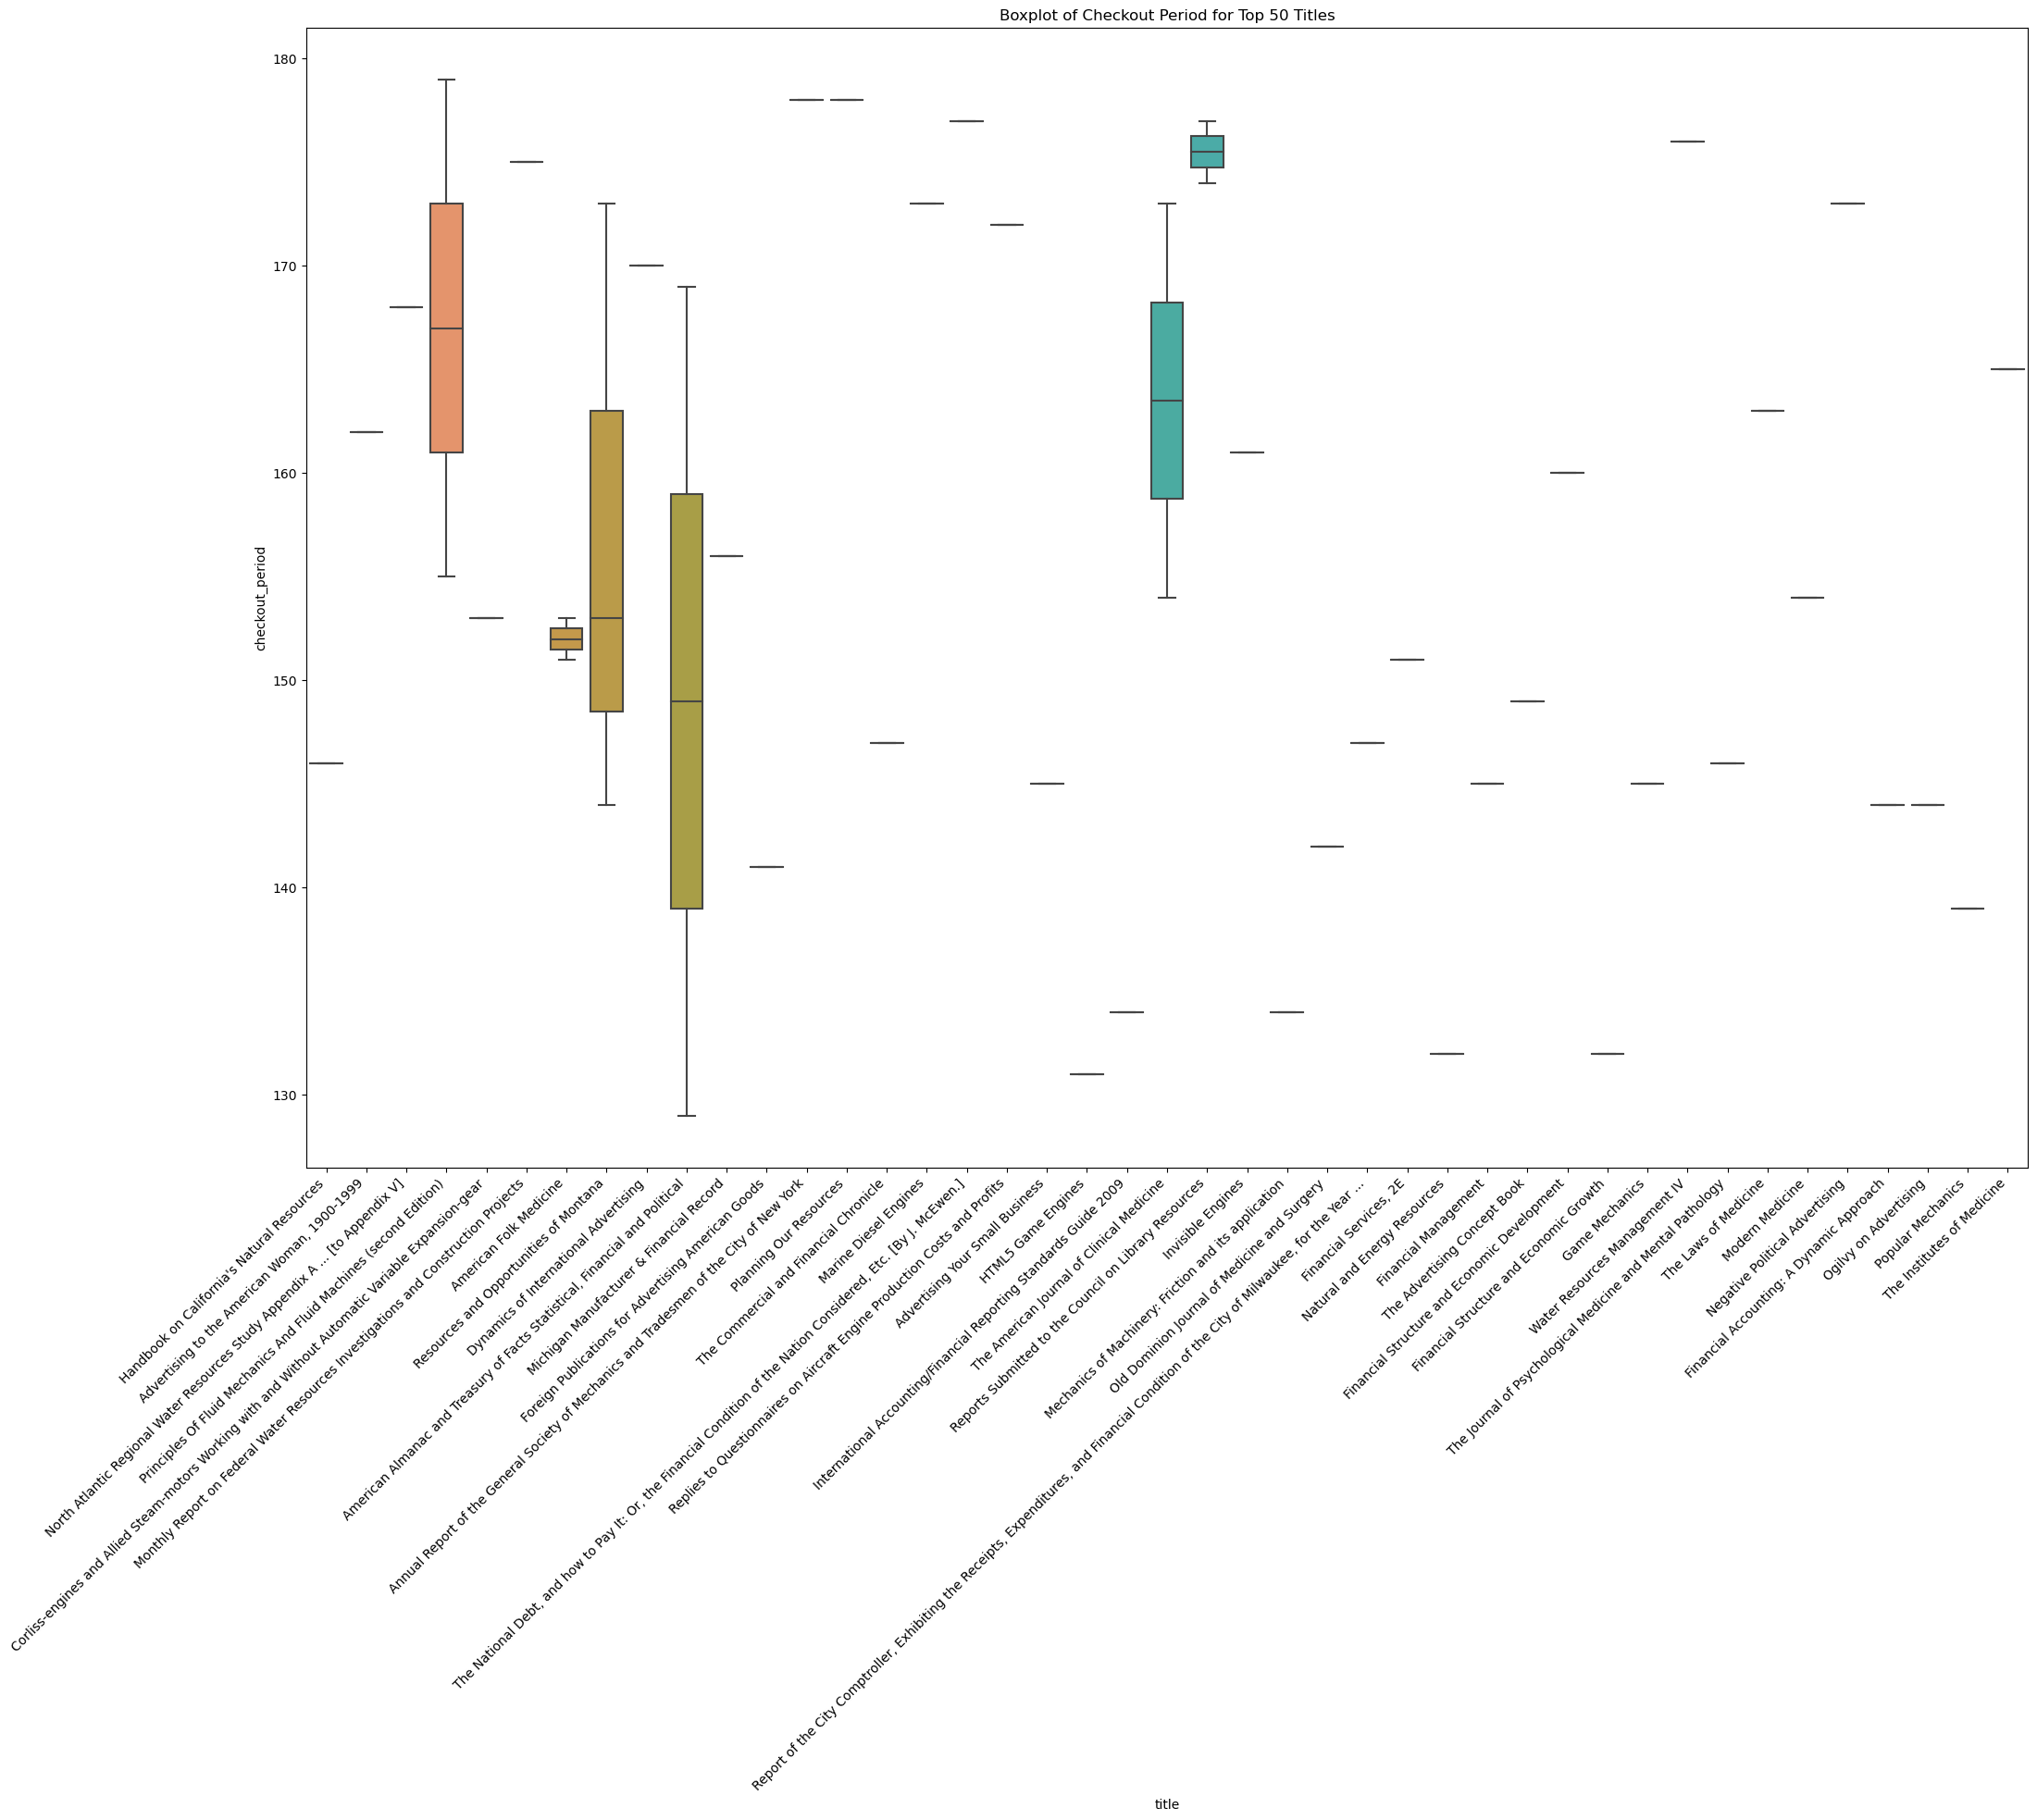

In [30]:
high_checkout_period = df_final['checkout_period'].nlargest(50)
df_top_books = df_final[df_final['checkout_period'].isin(high_checkout_period)]

plt.figure(figsize=(24, 16))
sns.boxplot(x="title", y="checkout_period", data=df_top_books)
plt.title('Boxplot of Checkout Period for Top 50 Titles')
plt.xticks(rotation=45, ha = 'right')
plt.show()

In [31]:
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df_final['age_group'] = pd.cut(df_final['age'], bins=bins, labels=labels)


##### *Distribution for different customer traits.*

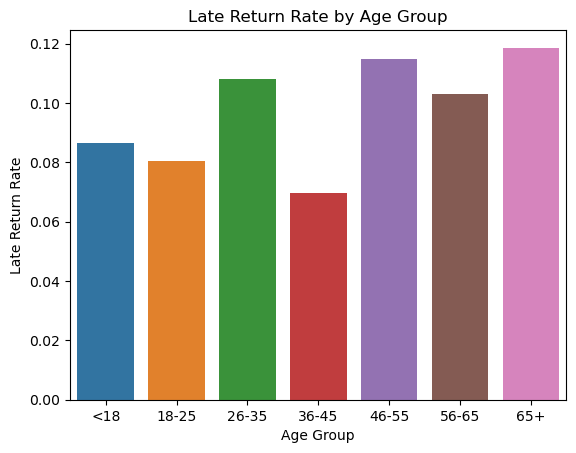

In [32]:
late_return_by_age = df_final.groupby('age_group')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_age, x='age_group', y='is_late_return')
plt.title('Late Return Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Late Return Rate')
plt.show()


##### *Students, people in business/finance and tech have the highest rate of lateness. The lowest rate was in the 36-45 age group.*

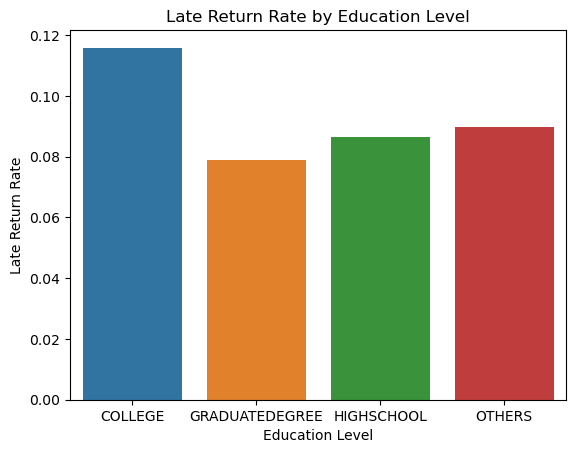

In [33]:
late_return_by_education = df_final.groupby('c_education')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_education, x='c_education', y='is_late_return')
plt.title('Late Return Rate by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Late Return Rate')
plt.show()

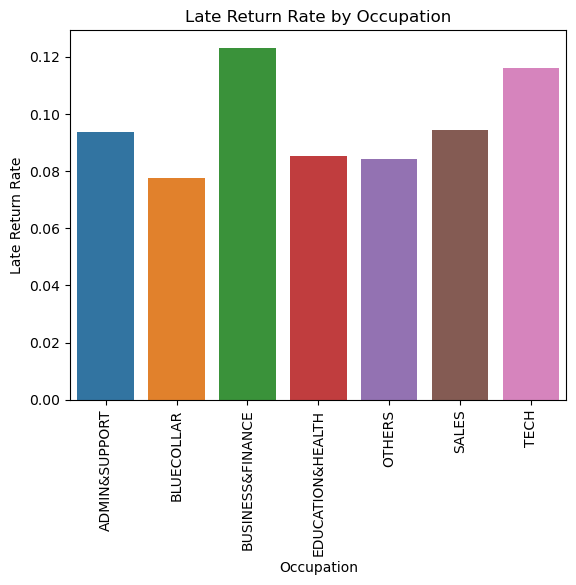

In [34]:
late_return_by_occupation = df_final.groupby('c_occupation')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_occupation, x='c_occupation', y='is_late_return')
plt.title('Late Return Rate by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()

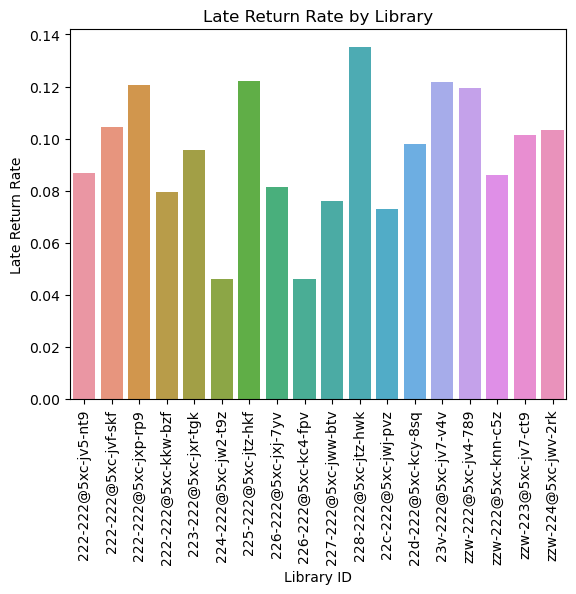

In [35]:
late_return_by_library = df_final.groupby('library_id')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_library, x='library_id', y='is_late_return')
plt.title('Late Return Rate by Library')
plt.xlabel('Library ID')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()


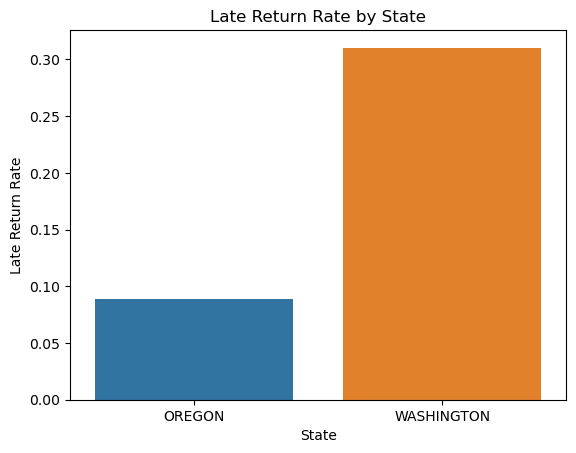

In [36]:
late_return_by_state = df_final.groupby('c_state')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_state, x='c_state', y='is_late_return')
plt.title('Late Return Rate by State')
plt.xlabel('State')
plt.ylabel('Late Return Rate')
plt.show()


         c_city  is_late_return
0     BEAVERTON        0.500000
1     CLACKAMAS        0.500000
2      DAMASCUS        0.000000
3     GLADSTONE        0.000000
4       GRESHAM        0.000000
5   HAPPYVALLEY        0.217391
6    LAKEOSWEGO        0.208333
7    OREGONCITY        0.666667
8      PORTLAND        0.069767
9      TUALATIN        0.333333
10    VANCOUVER        0.333333
11     WESTLINN        1.000000


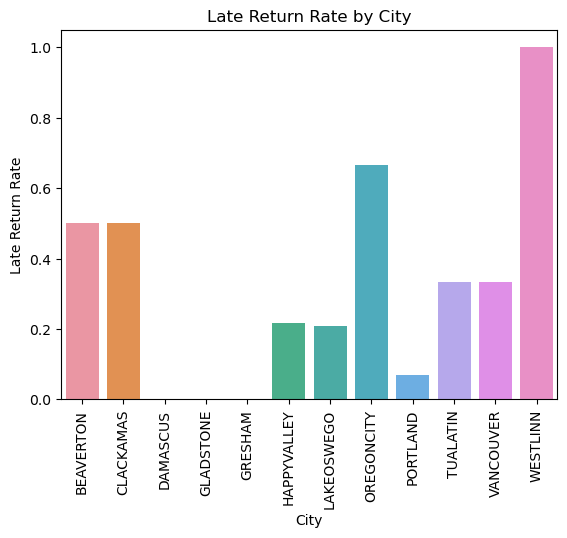

In [37]:
late_return_by_city = df_final.groupby('c_city')['is_late_return'].mean().reset_index()
print(late_return_by_city)
sns.barplot(data=late_return_by_city, x='c_city', y='is_late_return')
plt.title('Late Return Rate by City')
plt.xlabel('City')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()


In [38]:
df_final.c_city.value_counts()

c_city
PORTLAND       1333
VANCOUVER        30
LAKEOSWEGO       24
HAPPYVALLEY      23
BEAVERTON        20
OREGONCITY        6
WESTLINN          5
GRESHAM           3
TUALATIN          3
CLACKAMAS         2
DAMASCUS          1
GLADSTONE         1
Name: count, dtype: int64

##### *People from Washington have a much higher late return rate, but that's to be expected due to the fact that all the libraries are located in Oregon. For Damascus, Gladstone and Gresham the late return rate is 0, but this is because the amount of data available per city is small. Check the cell above*

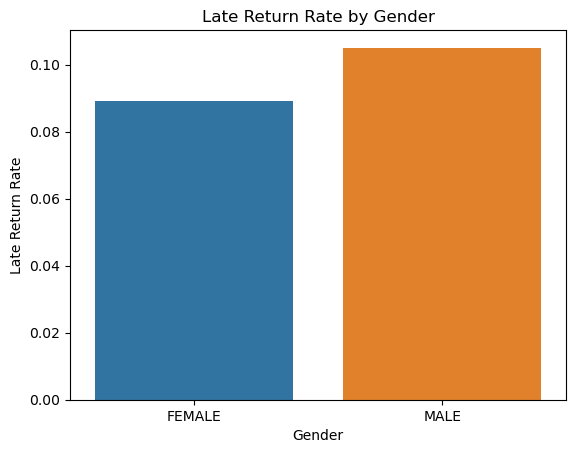

In [39]:
late_return_by_gender = df_final.groupby('c_gender')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_gender, x='c_gender', y='is_late_return')
plt.title('Late Return Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Late Return Rate')
plt.show()


          book_id  is_late_return
1    0mt9NdDSmYYC        0.500000
34   9SYBZggtr_IC        0.500000
37   9q1LAQAAIAAJ        0.666667
57   DlN0CAAAQBAJ        0.500000
71   I50-AQAAMAAJ        0.500000
83   N9V34rWEOGcC        1.000000
90   Oxw2AQAAMAAJ        0.600000
95   PSmsBwAAQBAJ        0.500000
133  YoLor8-zRDEC        0.500000
162  egEeAQAAIAAJ        0.600000
227  tvo3LZ-Qms0C        0.500000


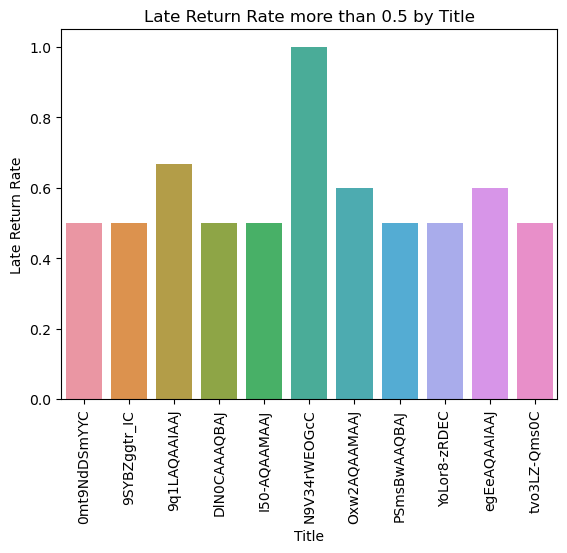

In [40]:
late_return_by_title = df_final.groupby('book_id')['is_late_return'].mean().reset_index()
print(late_return_by_title[late_return_by_title.is_late_return>=0.5])
sns.barplot(data=late_return_by_title[late_return_by_title.is_late_return>=0.5], x='book_id', y='is_late_return')
plt.title('Late Return Rate more than 0.5 by Title')
plt.xlabel('Title')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()


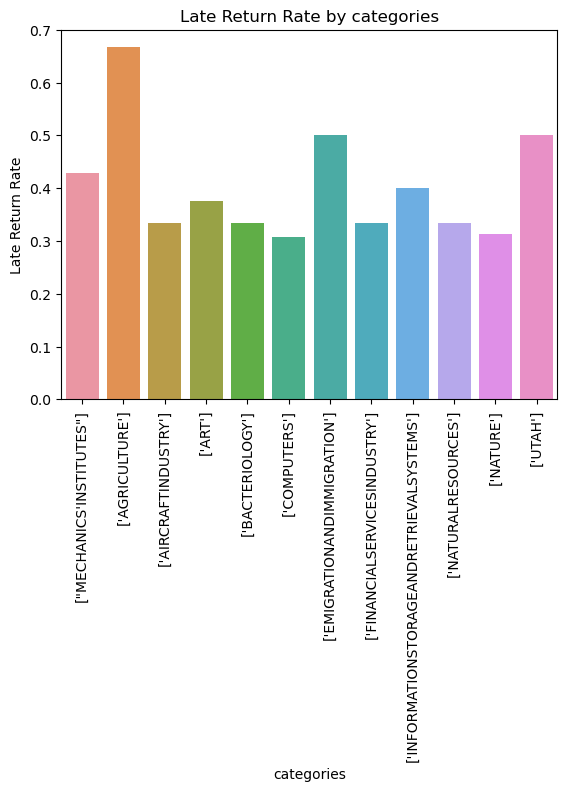

In [41]:
late_return_by_category = df_final.groupby('c_categories')['is_late_return'].mean().reset_index()

sns.barplot(data=late_return_by_category[late_return_by_category.is_late_return>=0.3], x='c_categories', y='is_late_return')
plt.title('Late Return Rate by categories')
plt.xlabel('categories')
plt.ylabel('Late Return Rate')
plt.xticks(rotation=90)
plt.show()


In [42]:
df_final.columns

Index(['customer_id', 'name', 'street_address', 'c_zipcode', 'c_gender',
       'c_city', 'c_state', 'c_occupation', 'c_education', 'c_birth_date',
       'book_id', 'library_id', 'c_date_checkout', 'c_date_returned',
       'checkout_period', 'is_late_return', 'title', 'authors', 'publisher',
       'c_categories', 'c_publishedDate', 'c_price', 'c_pages', 'age',
       'age_group'],
      dtype='object')

##### *The distribution of checking periods by different categories, shown above.*

C:\Users\HP Elitebook 840 g8\AppData\Local\Temp\ipykernel_47708\59491536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_data['return_status'] = boxplot_data['is_late_return'].map({True: 'Late Return', False: 'On-Time Return'})


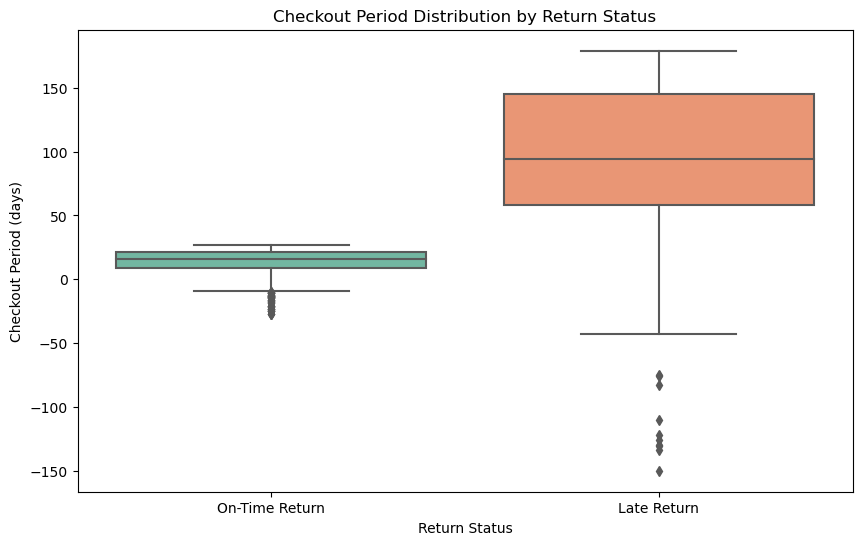

In [43]:
boxplot_data = df_final[['checkout_period', 'is_late_return']]
boxplot_data['return_status'] = boxplot_data['is_late_return'].map({True: 'Late Return', False: 'On-Time Return'})

plt.figure(figsize=(10, 6))
sns.boxplot(x='return_status', y='checkout_period', data=boxplot_data, palette='Set2')
plt.title('Checkout Period Distribution by Return Status')
plt.xlabel('Return Status')
plt.ylabel('Checkout Period (days)')
plt.show()


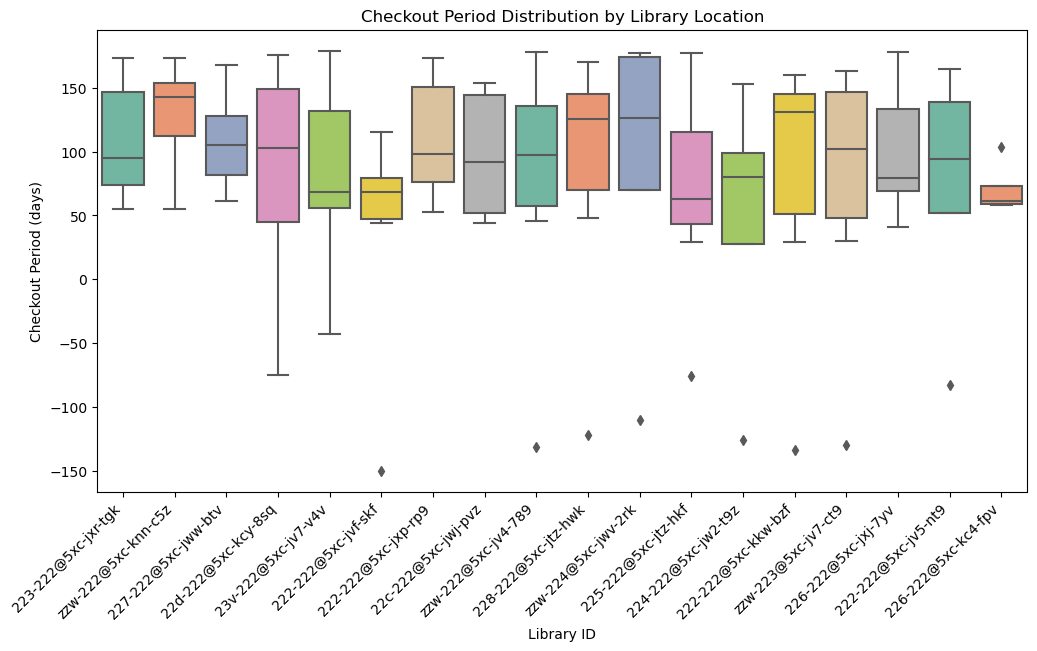

In [44]:
late_returns_data = df_final[df_final['is_late_return'] == True]
plt.figure(figsize=(12, 6))
sns.boxplot(x='library_id', y='checkout_period',  data=late_returns_data, palette='Set2')
plt.title('Checkout Period Distribution by Library Location')
plt.xlabel('Library ID')
plt.ylabel('Checkout Period (days)')
plt.xticks(rotation=45, ha = 'right') 
plt.show()


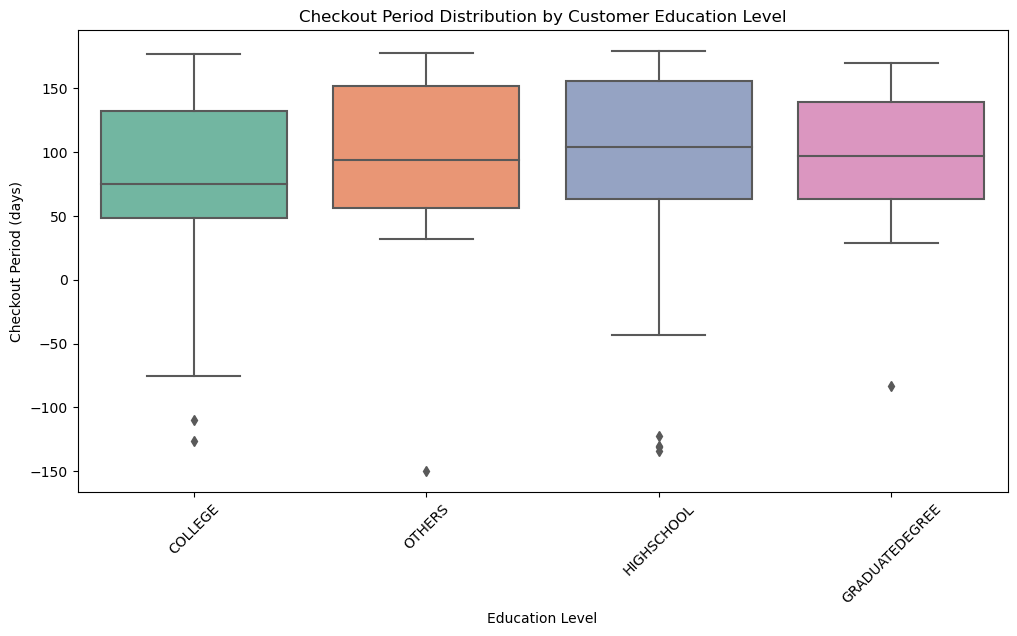

In [45]:
late_returns_data = df_final[df_final['is_late_return'] == True]

plt.figure(figsize=(12, 6))
sns.boxplot(x='c_education', y='checkout_period', data=late_returns_data, palette='Set2')
plt.title('Checkout Period Distribution by Customer Education Level')
plt.xlabel('Education Level')
plt.ylabel('Checkout Period (days)')
plt.xticks(rotation=45)
plt.show()


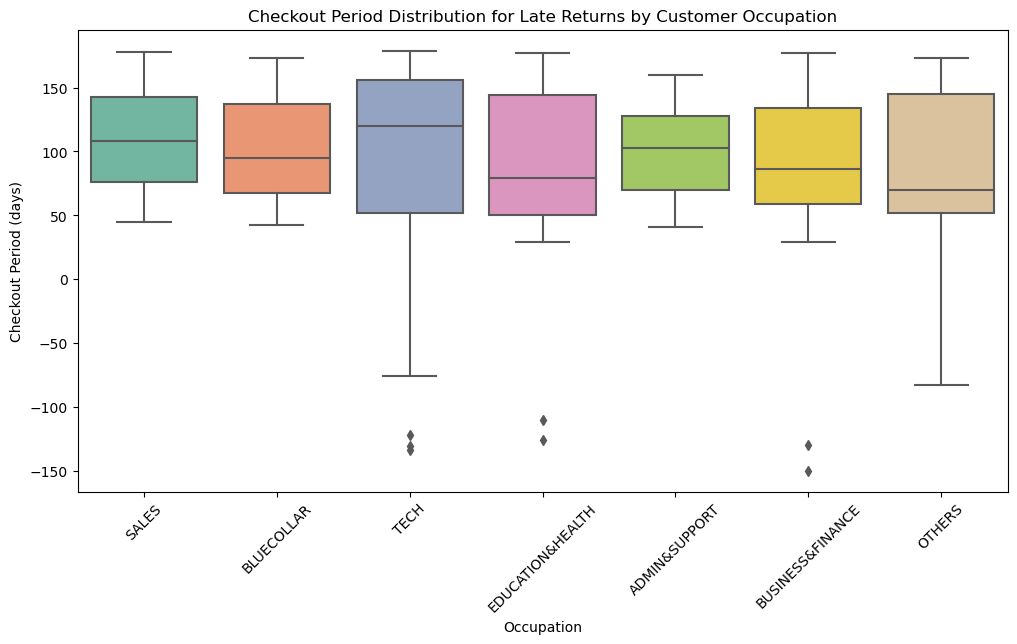

In [46]:
late_returns_data = df_final[df_final['is_late_return'] == True]

occupation_boxplot_data = late_returns_data[['checkout_period', 'c_occupation']]

plt.figure(figsize=(12, 6))
sns.boxplot(x='c_occupation', y='checkout_period', data=occupation_boxplot_data, palette='Set2')
plt.title('Checkout Period Distribution for Late Returns by Customer Occupation')
plt.xlabel('Occupation')
plt.ylabel('Checkout Period (days)')
plt.xticks(rotation=45)  
plt.show()

##### *Final steps to create datasets for model training.*

In [47]:
df_final['book_age'] = 2018 - pd.to_datetime(df_final['c_publishedDate']).dt.year


In [48]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526 entries, 0 to 1998
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      1526 non-null   object        
 1   name             1526 non-null   object        
 2   street_address   1526 non-null   object        
 3   c_zipcode        1526 non-null   float64       
 4   c_gender         1451 non-null   object        
 5   c_city           1451 non-null   object        
 6   c_state          1446 non-null   object        
 7   c_occupation     1443 non-null   object        
 8   c_education      1457 non-null   object        
 9   c_birth_date     1448 non-null   datetime64[ns]
 10  book_id          1526 non-null   object        
 11  library_id       1526 non-null   object        
 12  c_date_checkout  1526 non-null   datetime64[ns]
 13  c_date_returned  1526 non-null   datetime64[ns]
 14  checkout_period  1526 non-null   float64     

In [49]:
df_final.drop(columns=["name", "street_address", "c_zipcode", "c_birth_date", "authors","publisher", "title", "c_publishedDate","age_group"],inplace = True)

In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526 entries, 0 to 1998
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      1526 non-null   object        
 1   c_gender         1451 non-null   object        
 2   c_city           1451 non-null   object        
 3   c_state          1446 non-null   object        
 4   c_occupation     1443 non-null   object        
 5   c_education      1457 non-null   object        
 6   book_id          1526 non-null   object        
 7   library_id       1526 non-null   object        
 8   c_date_checkout  1526 non-null   datetime64[ns]
 9   c_date_returned  1526 non-null   datetime64[ns]
 10  checkout_period  1526 non-null   float64       
 11  is_late_return   1526 non-null   bool          
 12  c_categories     1292 non-null   object        
 13  c_price          1515 non-null   float64       
 14  c_pages          1526 non-null   float64     

In [51]:
df_final['c_occupation'].fillna('Unknown', inplace=True)
df_final['c_education'].fillna('Unknown', inplace=True)
df_final['c_city'].fillna('Unknown', inplace=True)
df_final['c_state'].fillna('Unknown', inplace=True)
df_final['c_gender'].fillna('Unknown', inplace=True)
df_final['c_categories'].fillna('Unknown', inplace=True)
df_final['age'].fillna(df_final['age'].median(), inplace=True)
df_final['book_age'].fillna(df_final['book_age'].median(), inplace=True)
df_final['c_price'].fillna(df_final['c_price'].mean(), inplace=True)


In [52]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1526 entries, 0 to 1998
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      1526 non-null   object        
 1   c_gender         1526 non-null   object        
 2   c_city           1526 non-null   object        
 3   c_state          1526 non-null   object        
 4   c_occupation     1526 non-null   object        
 5   c_education      1526 non-null   object        
 6   book_id          1526 non-null   object        
 7   library_id       1526 non-null   object        
 8   c_date_checkout  1526 non-null   datetime64[ns]
 9   c_date_returned  1526 non-null   datetime64[ns]
 10  checkout_period  1526 non-null   float64       
 11  is_late_return   1526 non-null   bool          
 12  c_categories     1526 non-null   object        
 13  c_price          1526 non-null   float64       
 14  c_pages          1526 non-null   float64     

In [53]:
library_late_rate = df_final.groupby('library_id')['is_late_return'].mean().reset_index().rename(columns={'is_late_return': 'library_late_rate'})
df_final = pd.merge(df_final, library_late_rate, on='library_id', how='left')
book_late_rate = df_final.groupby('book_id')['is_late_return'].mean().reset_index().rename(columns={'is_late_return': 'book_late_rate'})
df_final = pd.merge(df_final, book_late_rate, on='book_id', how='left')

In [55]:
df_final.drop(columns=['book_id','library_id'], inplace = True)

In [56]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        1526 non-null   object        
 1   c_gender           1526 non-null   object        
 2   c_city             1526 non-null   object        
 3   c_state            1526 non-null   object        
 4   c_occupation       1526 non-null   object        
 5   c_education        1526 non-null   object        
 6   c_date_checkout    1526 non-null   datetime64[ns]
 7   c_date_returned    1526 non-null   datetime64[ns]
 8   checkout_period    1526 non-null   float64       
 9   is_late_return     1526 non-null   bool          
 10  c_categories       1526 non-null   object        
 11  c_price            1526 non-null   float64       
 12  c_pages            1526 non-null   float64       
 13  age                1526 non-null   float64       
 14  book_age

In [57]:
df = pd.get_dummies(df_final, columns=['c_gender', 'c_state', 'c_education'], drop_first=True)

In [58]:
df_final.to_csv("for_model.csv")

In [59]:
df_final['c_occupation'] = LabelEncoder().fit_transform(df_final['c_occupation'])
df_final['c_gender'] = LabelEncoder().fit_transform(df_final['c_gender'])
df_final['c_city'] = LabelEncoder().fit_transform(df_final['c_city'])
df_final['c_state'] = LabelEncoder().fit_transform(df_final['c_state'])
df_final['c_education'] = LabelEncoder().fit_transform(df_final['c_education'])
df_final['c_categories'] = LabelEncoder().fit_transform(df_final['c_categories']) 

scaler = MinMaxScaler()
df_final[['c_price', 'c_pages','age', 'book_age']] = scaler.fit_transform(df_final[['c_price', 'c_pages','age', 'book_age']])


In [60]:
df_final.drop(columns=['customer_id'], inplace = True)

In [61]:
df_final.drop(columns=['c_date_checkout','c_date_returned'], inplace = True)

In [62]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526 entries, 0 to 1525
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   c_gender           1526 non-null   int32  
 1   c_city             1526 non-null   int32  
 2   c_state            1526 non-null   int32  
 3   c_occupation       1526 non-null   int32  
 4   c_education        1526 non-null   int32  
 5   checkout_period    1526 non-null   float64
 6   is_late_return     1526 non-null   bool   
 7   c_categories       1526 non-null   int32  
 8   c_price            1526 non-null   float64
 9   c_pages            1526 non-null   float64
 10  age                1526 non-null   float64
 11  book_age           1526 non-null   float64
 12  library_late_rate  1526 non-null   float64
 13  book_late_rate     1526 non-null   float64
dtypes: bool(1), float64(7), int32(6)
memory usage: 120.8 KB


In [63]:
df_final.drop(columns=['checkout_period'], inplace = True)

##### *Spliting data and start training models*

In [64]:
X = df_final.drop(columns=['is_late_return'])
y = df_final['is_late_return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [66]:


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.93      0.98      0.95       277
        True       0.62      0.28      0.38        29

    accuracy                           0.92       306
   macro avg       0.77      0.63      0.67       306
weighted avg       0.90      0.92      0.90       306



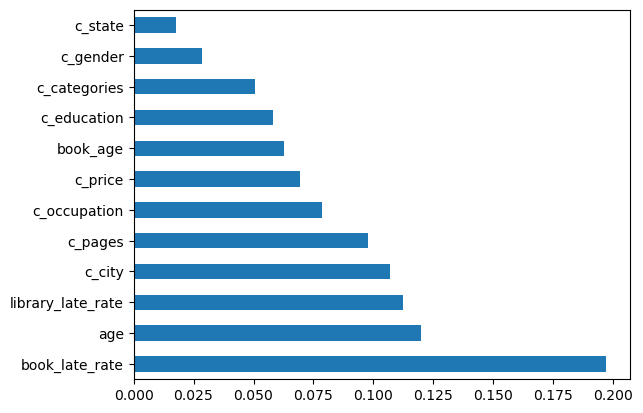

In [67]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(12).plot(kind='barh')
plt.show()


In [68]:
X_train.columns

Index(['c_gender', 'c_city', 'c_state', 'c_occupation', 'c_education',
       'c_categories', 'c_price', 'c_pages', 'age', 'book_age',
       'library_late_rate', 'book_late_rate'],
      dtype='object')

In [69]:
X_train.book_late_rate.value_counts()

book_late_rate
0.000000    684
0.111111     68
0.142857     60
0.125000     50
0.333333     45
0.285714     37
0.090909     36
0.166667     36
0.200000     35
0.100000     28
0.250000     25
0.500000     24
0.083333     20
0.375000     14
0.071429     11
0.181818     10
0.222222      8
0.400000      8
0.428571      6
0.600000      6
0.444444      4
0.666667      4
1.000000      1
Name: count, dtype: int64

In [70]:
X_test.book_late_rate.value_counts()

book_late_rate
0.000000    164
0.142857     17
0.125000     14
0.111111     13
0.166667     12
0.100000     12
0.200000     10
0.500000     10
0.333333      9
0.090909      8
0.250000      7
0.444444      5
0.285714      5
0.600000      4
0.083333      4
0.071429      3
0.375000      2
0.666667      2
0.400000      2
0.222222      1
0.428571      1
0.181818      1
Name: count, dtype: int64

In [71]:

models = {
    'Logistic Regression_1': LogisticRegression(),
    'Logistic Regression_2':LogisticRegression(solver='newton-cg',penalty='none',max_iter=1000),
    'Logistic Regression_3':LogisticRegression(solver='lbfgs',penalty='none',max_iter=500),
    'Logistic Regression_4':LogisticRegression(solver='sag',penalty='none',max_iter=1000),
    'Logistic Regression_5':LogisticRegression(solver='saga',penalty='none',max_iter=1500),
    'Random Forest_1': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest_2': RandomForestClassifier(n_estimators=200, random_state=42),
    'XGBoost_1': XGBClassifier(use_label_encoder=False, eval_metric='logloss', maxdepth = 3, learning_rate = 0.01),
    'XGBoost_2': XGBClassifier(use_label_encoder=False, eval_metric='logloss', maxdepth = 5, learning_rate = 0.1),
    'Support Vector Machine_1': SVC(probability=True, kernel='linear'),
    'Support Vector Machine_2': SVC(probability=True, kernel='poly', degree = 5),
    'Support Vector Machine_3': SVC(probability=True, kernel='rbf', gamma = 0.1),
    'K-Nearest Neighbors_1': KNeighborsClassifier(n_neighbors=4),
    'K-Nearest Neighbors_2': KNeighborsClassifier(n_neighbors=3),
    'MLP Classifier_1': MLPClassifier(max_iter=500),
    'MLP Classifier_2': MLPClassifier(max_iter=300),
    'CatBoost_1': CatBoostClassifier(iterations=100, learning_rate=0.05, depth=4, verbose=0),
    'CatBoost_2': CatBoostClassifier(iterations=200, learning_rate=0.01, depth=6, verbose=0),
    'Naive Bayes': GaussianNB()
}

for model_name, model in models.items():
    pipeline = Pipeline(steps=[('model', model)])


    history = pipeline.fit(X_train, y_train)


    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] 

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    loss = log_loss(y_test, y_pred_proba) 
    
    print(f'{model_name} Metrics:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print(f'  ROC AUC: {roc_auc:.4f}')
    print(f'  Loss: {loss:.4f}\n')

C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=

Logistic Regression_1 Metrics:
  Accuracy: 0.9216
  Precision: 0.7273
  Recall: 0.2759
  F1 Score: 0.4000
  ROC AUC: 0.8717
  Loss: 0.2254

Logistic Regression_2 Metrics:
  Accuracy: 0.9150
  Precision: 0.5789
  Recall: 0.3793
  F1 Score: 0.4583
  ROC AUC: 0.8612
  Loss: 0.2272

Logistic Regression_3 Metrics:
  Accuracy: 0.9150
  Precision: 0.5789
  Recall: 0.3793
  F1 Score: 0.4583
  ROC AUC: 0.8609
  Loss: 0.2272



C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Logistic Regression_4 Metrics:
  Accuracy: 0.9183
  Precision: 0.6667
  Recall: 0.2759
  F1 Score: 0.3902
  ROC AUC: 0.8622
  Loss: 0.2289



C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression_5 Metrics:
  Accuracy: 0.9216
  Precision: 0.7273
  Recall: 0.2759
  F1 Score: 0.4000
  ROC AUC: 0.8499
  Loss: 0.2339

Random Forest_1 Metrics:
  Accuracy: 0.9150
  Precision: 0.6154
  Recall: 0.2759
  F1 Score: 0.3810
  ROC AUC: 0.8361
  Loss: 0.3434

Random Forest_2 Metrics:
  Accuracy: 0.9085
  Precision: 0.5385
  Recall: 0.2414
  F1 Score: 0.3333
  ROC AUC: 0.8369
  Loss: 0.3427

XGBoost_1 Metrics:
  Accuracy: 0.9183
  Precision: 1.0000
  Recall: 0.1379
  F1 Score: 0.2424
  ROC AUC: 0.8712
  Loss: 0.2444



C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "maxdepth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "maxdepth", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost_2 Metrics:
  Accuracy: 0.9052
  Precision: 0.5000
  Recall: 0.3448
  F1 Score: 0.4082
  ROC AUC: 0.8307
  Loss: 0.2690



C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine_1 Metrics:
  Accuracy: 0.9052
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.8341
  Loss: 0.2927



C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine_2 Metrics:
  Accuracy: 0.9052
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.6661
  Loss: 0.3005

Support Vector Machine_3 Metrics:
  Accuracy: 0.9052
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.6826
  Loss: 0.2971

K-Nearest Neighbors_1 Metrics:
  Accuracy: 0.9052
  Precision: 0.5000
  Recall: 0.0345
  F1 Score: 0.0645
  ROC AUC: 0.5980
  Loss: 2.1219

K-Nearest Neighbors_2 Metrics:
  Accuracy: 0.9052
  Precision: 0.5000
  Recall: 0.1379
  F1 Score: 0.2162
  ROC AUC: 0.5843
  Loss: 2.3468

MLP Classifier_1 Metrics:
  Accuracy: 0.9020
  Precision: 0.4737
  Recall: 0.3103
  F1 Score: 0.3750
  ROC AUC: 0.8375
  Loss: 0.2476

MLP Classifier_2 Metrics:
  Accuracy: 0.9150
  Precision: 0.6154
  Recall: 0.2759
  F1 Score: 0.3810
  ROC AUC: 0.8163
  Loss: 0.2614

CatBoost_1 Metrics:
  Accuracy: 0.9248
  Precision: 1.0000
  Recall: 0.2069
  F1 Score: 0.3429
  ROC AUC: 0.8857
  Loss: 0.2161

CatBoost_2 Metrics:
  Accuracy: 0.9

##### *Looking at all metrics, the best performance has CatBoost_2 and Logistic Regressions. But also the rest of the models are also pretty similar with results. As the lowest performance model I would select SVMs and KKN_1 due to poor Precision, Recall (sensitivity) and F1 score.*

In [72]:
model = Sequential([
    Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],)),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history =model.fit(X_train, y_train, epochs=250, batch_size=128, verbose=2, validation_split=0.1)





Epoch 1/250


9/9 - 1s - loss: 1.3818 - accuracy: 0.0938 - val_loss: 1.2551 - val_accuracy: 0.0902 - 1s/epoch - 135ms/step
Epoch 2/250
9/9 - 0s - loss: 1.1691 - accuracy: 0.0938 - val_loss: 1.0639 - val_accuracy: 0.0902 - 49ms/epoch - 5ms/step
Epoch 3/250
9/9 - 0s - loss: 0.9954 - accuracy: 0.0938 - val_loss: 0.9121 - val_accuracy: 0.0902 - 47ms/epoch - 5ms/step
Epoch 4/250
9/9 - 0s - loss: 0.8580 - accuracy: 0.0938 - val_loss: 0.7940 - val_accuracy: 0.0902 - 46ms/epoch - 5ms/step
Epoch 5/250
9/9 - 0s - loss: 0.7534 - accuracy: 0.0938 - val_loss: 0.7025 - val_accuracy: 0.0902 - 62ms/epoch - 7ms/step
Epoch 6/250
9/9 - 0s - loss: 0.6716 - accuracy: 0.7596 - val_loss: 0.6324 - val_accuracy: 0.9098 - 63ms/epoch - 7ms/step
Epoch 7/250
9/9 - 0s - loss: 0.6092 - accuracy: 0.9062 - val_loss: 0.5784 - val_accuracy: 0.9098 - 52ms/epoch - 6ms/step
Epoch 8/250
9/9 - 0s - loss: 0.5609 - accuracy: 0.9062 - val_loss: 0.5367 - val_accuracy: 0.9098 - 61ms/epoch - 7ms/step
Epoch 9/250
9/9 - 0s - loss:

Epoch 61/250
9/9 - 0s - loss: 0.3113 - accuracy: 0.9062 - val_loss: 0.3035 - val_accuracy: 0.9098 - 53ms/epoch - 6ms/step
Epoch 62/250
9/9 - 0s - loss: 0.3113 - accuracy: 0.9062 - val_loss: 0.3035 - val_accuracy: 0.9098 - 65ms/epoch - 7ms/step
Epoch 63/250
9/9 - 0s - loss: 0.3113 - accuracy: 0.9062 - val_loss: 0.3035 - val_accuracy: 0.9098 - 65ms/epoch - 7ms/step
Epoch 64/250
9/9 - 0s - loss: 0.3113 - accuracy: 0.9062 - val_loss: 0.3034 - val_accuracy: 0.9098 - 62ms/epoch - 7ms/step
Epoch 65/250
9/9 - 0s - loss: 0.3112 - accuracy: 0.9062 - val_loss: 0.3034 - val_accuracy: 0.9098 - 60ms/epoch - 7ms/step
Epoch 66/250
9/9 - 0s - loss: 0.3112 - accuracy: 0.9062 - val_loss: 0.3033 - val_accuracy: 0.9098 - 59ms/epoch - 7ms/step
Epoch 67/250
9/9 - 0s - loss: 0.3112 - accuracy: 0.9062 - val_loss: 0.3033 - val_accuracy: 0.9098 - 53ms/epoch - 6ms/step
Epoch 68/250
9/9 - 0s - loss: 0.3112 - accuracy: 0.9062 - val_loss: 0.3033 - val_accuracy: 0.9098 - 50ms/epoch - 6ms/step
Epoch 69/250
9/9 - 0s - 

Epoch 128/250
9/9 - 0s - loss: 0.3091 - accuracy: 0.9062 - val_loss: 0.3038 - val_accuracy: 0.9098 - 54ms/epoch - 6ms/step
Epoch 129/250
9/9 - 0s - loss: 0.3088 - accuracy: 0.9062 - val_loss: 0.3039 - val_accuracy: 0.9098 - 64ms/epoch - 7ms/step
Epoch 130/250
9/9 - 0s - loss: 0.3086 - accuracy: 0.9062 - val_loss: 0.3040 - val_accuracy: 0.9098 - 66ms/epoch - 7ms/step
Epoch 131/250
9/9 - 0s - loss: 0.3083 - accuracy: 0.9062 - val_loss: 0.3042 - val_accuracy: 0.9098 - 51ms/epoch - 6ms/step
Epoch 132/250
9/9 - 0s - loss: 0.3079 - accuracy: 0.9062 - val_loss: 0.3042 - val_accuracy: 0.9098 - 53ms/epoch - 6ms/step
Epoch 133/250
9/9 - 0s - loss: 0.3075 - accuracy: 0.9062 - val_loss: 0.3040 - val_accuracy: 0.9098 - 65ms/epoch - 7ms/step
Epoch 134/250
9/9 - 0s - loss: 0.3071 - accuracy: 0.9062 - val_loss: 0.3040 - val_accuracy: 0.9098 - 69ms/epoch - 8ms/step
Epoch 135/250
9/9 - 0s - loss: 0.3066 - accuracy: 0.9062 - val_loss: 0.3042 - val_accuracy: 0.9098 - 54ms/epoch - 6ms/step
Epoch 136/250
9/

Epoch 195/250
9/9 - 0s - loss: 0.2288 - accuracy: 0.9162 - val_loss: 0.2552 - val_accuracy: 0.9098 - 45ms/epoch - 5ms/step
Epoch 196/250
9/9 - 0s - loss: 0.2293 - accuracy: 0.9144 - val_loss: 0.2650 - val_accuracy: 0.9098 - 44ms/epoch - 5ms/step
Epoch 197/250
9/9 - 0s - loss: 0.2288 - accuracy: 0.9126 - val_loss: 0.2585 - val_accuracy: 0.9098 - 42ms/epoch - 5ms/step
Epoch 198/250
9/9 - 0s - loss: 0.2274 - accuracy: 0.9135 - val_loss: 0.2606 - val_accuracy: 0.9098 - 54ms/epoch - 6ms/step
Epoch 199/250
9/9 - 0s - loss: 0.2272 - accuracy: 0.9144 - val_loss: 0.2583 - val_accuracy: 0.9098 - 54ms/epoch - 6ms/step
Epoch 200/250
9/9 - 0s - loss: 0.2284 - accuracy: 0.9153 - val_loss: 0.2646 - val_accuracy: 0.9098 - 43ms/epoch - 5ms/step
Epoch 201/250
9/9 - 0s - loss: 0.2280 - accuracy: 0.9135 - val_loss: 0.2667 - val_accuracy: 0.9098 - 47ms/epoch - 5ms/step
Epoch 202/250
9/9 - 0s - loss: 0.2256 - accuracy: 0.9171 - val_loss: 0.2540 - val_accuracy: 0.9098 - 44ms/epoch - 5ms/step
Epoch 203/250
9/

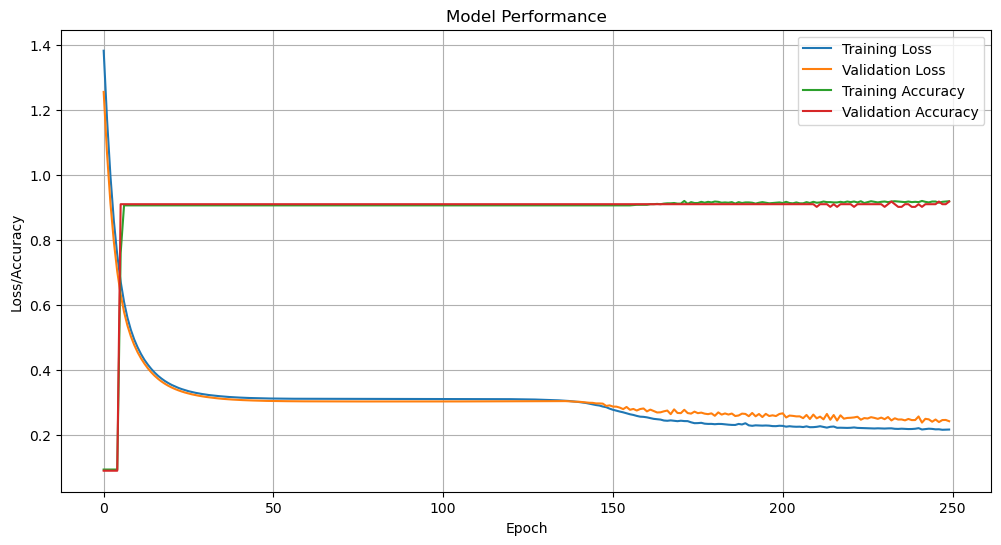

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Performance')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()


In [74]:
y_pred_proba = model.predict(X_test).flatten()  
y_pred = (y_pred_proba >= 0.5).astype(int) 
print(f"TensorFlow Model Accuracy: {accuracy:.4f}")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print('TensorFlow Model Metrics:')
print(f'  Accuracy: {accuracy:.4f}')
print(f'  Precision: {precision:.4f}')
print(f'  Recall: {recall:.4f}')
print(f'  F1 Score: {f1:.4f}')
print(f'  ROC AUC: {roc_auc:.4f}')

10/10 [==============================] - 0s 2ms/step
TensorFlow Model Accuracy: 0.8791
TensorFlow Model Metrics:
  Accuracy: 0.8791
  Precision: 0.5263
  Recall: 0.3448
  F1 Score: 0.4167
  ROC AUC: 0.8558


##### *Based on the results, better results come from the model above.*

In [75]:
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets)
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

model = SimpleNN()
criterion = FocalLoss(gamma = 1.,alpha=0.1,reduction = 'sum' )
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()


model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_labels = (y_pred > 0.5).float() 


accuracy = (y_pred_labels.eq(y_test_tensor).sum().item()) / y_test_tensor.shape[0]
print(f"PyTorch Model Accuracy with Focal Loss: {accuracy:.4f}")

PyTorch Model Accuracy with Focal Loss: 0.9052


In [76]:
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred)

print('PyTorch Model Metrics:')
print(f'  Accuracy: {accuracy:.4f}')
print(f'  Precision: {precision:.4f}')
print(f'  Recall: {recall:.4f}')
print(f'  F1 Score: {f1:.4f}')
print(f'  ROC AUC: {roc_auc:.4f}')

PyTorch Model Metrics:
  Accuracy: 0.9052
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5744


C:\Users\HP Elitebook 840 g8\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Answer to quiestion:

## Q1: Are there any factors you can find that are connected with late returns?

### A1:
Yes, several factors are connected with late returns:

- **Library Location**: Out-of-state users are much more likely to return books late.
- **Book Length**: Books with more pages tend to come back later, likely due to the longer time required to read them.
- **Student Behavior**: Students tend to keep books longer, possibly because of limited availability during exam periods.
- **Occupation**: People working in business, finance, and tech are more likely to return books late, possibly due to a busy schedule or forgetfulness.
- **Library-Specific Trends**: Some libraries show significantly higher late return rates, which could be attributed to their geographical location.
- **Book Categories**: Books related to Agriculture, Emigration Administration, and topics about Utah show higher late return rates.

### Suggested Action:
A potential solution is to buy more copies of frequently delayed books and notify users in advance if they borrow high-demand items.


## Q2: What would you recommend the library do to mitigate the risks you find?

### A2:
To mitigate the risks of late returns, I suggest the following:

- **Library App**: Develop a library app that allows users to track borrowed books, check due dates, and receive notifications before their return deadline.
    - Users could also post book reviews and receive positive ratings for timely returns.
    - Introduce a point system where users earn rewards for on-time returns, which could lead to discounts or other benefits.
- **Fines and Deposits**: Implement a penalty system for overdue books after a certain threshold (e.g., 52 days) or a deposit system for high-value books, which gets refunded upon return.
    - However, careful consideration is needed as this could reduce the number of users.


## Q3: How would you present your findings to get buy-in from the library?

### A3:
To gain buy-in from the library, I would:

- **Visualize the Data**: Use easy-to-read charts and graphs to show late return trends and patterns. This will make it clear which factors contribute most to late returns.
- **Simulate Proposed Solutions**: Demonstrate how implementing the app or other solutions would improve return rates.
- **Highlight Benefits**: Emphasize how the proposed solutions would simplify operations for the library and improve customer satisfaction.
- **Data-Driven Insights**: Present additional market analysis and customer behavior data to back up the proposed strategy.


## Conclusion

The analysis identifies clear factors that influence late returns, including the user's location, book length, and occupation. By implementing a tracking app, improving communication with users, and introducing reward systems, the library can significantly reduce late return rates and enhance user satisfaction.
